<a href="https://colab.research.google.com/github/eduardez/Machine-Learning-ESI/blob/master/Copia_de_Dengue_Task_2_ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import VotingRegressor

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')


from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# No presteis demasiada atencion a estos metodos que son solo porque me da un poco de TOC tener las tablas una detras de otra
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


#Preparacion

In [3]:
# load the provided data
train_features_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC',
                             index_col=[0,1,2])

train_labels_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ',
                           index_col=[0,1,2])

features_test_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=ANLXPWOAY3AS6JWDRSIMHI276CDY6',
                           index_col=[0,1,2])

submission = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/submission_format.csv?token=ANLXPWPCMTBVVHBSCUFJB5C76CEHE',
                           index_col=[0,1,2])

In [4]:
train_features = train_features_raw.copy()
train_labels = train_labels_raw.copy()

In [5]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [6]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [7]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

In [8]:
# Null check
print(pd.isnull(sj_train_features).sum())
print('--------------------------------')
print(pd.isnull(iq_train_features).sum())

ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_min_temp_c                         6
station_precip_mm                          6
dtype: int64
--------------------------------
ndvi_ne                                   3
ndvi_nw   

In [9]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

In [10]:
sj_train_features = sj_train_features.shift(periods = 5, fill_value = 0)
iq_train_features = iq_train_features.shift(periods = 5, fill_value = 0)

In [11]:
sj_train_features

ndvi_ne   ndvi_nw  ...  station_min_temp_c  station_precip_mm
year weekofyear                     ...                                       
1990 18          0.00000  0.000000  ...                 0.0                0.0
     19          0.00000  0.000000  ...                 0.0                0.0
     20          0.00000  0.000000  ...                 0.0                0.0
     21          0.00000  0.000000  ...                 0.0                0.0
     22          0.00000  0.000000  ...                 0.0                0.0
...                  ...       ...  ...                 ...                ...
2008 13         -0.13865 -0.095067  ...                21.7               13.3
     14         -0.13865  0.015420  ...                21.1               12.9
     15         -0.08890 -0.090033  ...                21.1               13.0
     16         -0.32140 -0.141200  ...                22.2                4.4
     17          0.04490  0.024450  ...                20.6                0.5

[936 rows x 20 columns]

In [12]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

In [13]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

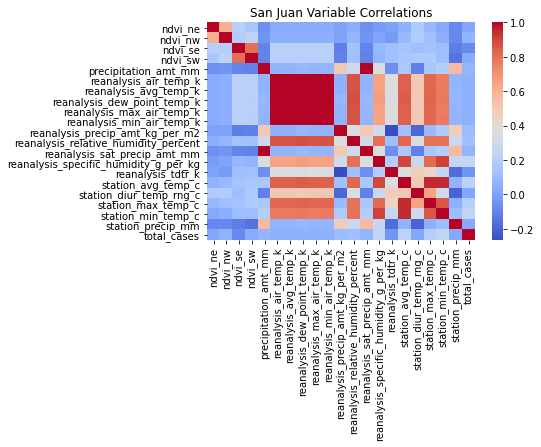

In [14]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('San Juan Variable Correlations')

# Model based prediction


In [15]:
#@title Prediction config
#@markdown Periods
sj_period = 5 #@param {type:"slider", min:0, max:20, step:1}
iq_period = 2 #@param {type:"slider", min:0, max:20, step:1}

#@markdown Train-Test number
sj_training_numb =  800#@param {type:"integer"}
iq_training_numb = 400 #@param {type:"integer"}

# Features
selected_features = ['reanalysis_specific_humidity_g_per_kg', 
              #'reanalysis_dew_point_temp_k', 
              'station_avg_temp_c', 
              'station_min_temp_c',
              'ndvi_se',
              'ndvi_sw',
              ]



## Data


### Data load


In [16]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    sj = sj.shift(periods = sj_period, fill_value = 0)
    iq = iq.shift(periods = iq_period, fill_value = 0)
    return sj, iq

In [17]:
sj_train_raw, iq_train_raw = preprocess_data('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC', labels_path="https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ")
sj_test_pred, iq_test_pred = preprocess_data('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=ANLXPWOAY3AS6JWDRSIMHI276CDY6')


### Dataset division

In [18]:
sj_train = sj_train_raw.copy()
sj_train.reset_index(drop = True, inplace = True)
sj_train_subtrain = sj_train.head(sj_training_numb)  #Parte de train
sj_train_subtest = sj_train.tail(sj_train.shape[0] - sj_training_numb) #Parte de test

iq_train = iq_train_raw.copy()
iq_train.reset_index(drop = True, inplace = True)
iq_train_subtrain = iq_train.head(iq_training_numb)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - iq_training_numb)


In [19]:
sj_x_train = sj_train_subtrain[selected_features]
sj_y_train = sj_train_subtrain['total_cases']
sj_x_test = sj_train_subtest[selected_features]
sj_y_test = sj_train_subtest['total_cases']

iq_x_train = iq_train_subtrain[selected_features]
iq_y_train = iq_train_subtrain['total_cases']
iq_x_test = iq_train_subtest[selected_features]
iq_y_test = iq_train_subtest['total_cases']

#Model Configuration


In [20]:
#@title #SAN JUAN Model Config
#@markdown ### San Juan
use_RANDOM_FOREST_sj = True #@param {type:"boolean"}
use_DECISION_TREE_sj = True #@param {type:"boolean"}
use_ADABOOST_sj = False #@param {type:"boolean"}
use_STOCH_GRAD_sj = False #@param {type:"boolean"}
use_VOTING_sj = True #@param {type:"boolean"}
use_PROPHET_sj = True #@param {type:"boolean"}
use_PD_MEAN_sj = True #@param {type:"boolean"}

#@markdown ### Iquitos
use_RANDOM_FOREST_iq = True #@param {type:"boolean"}
use_DECISION_TREE_iq = True #@param {type:"boolean"}
use_ADABOOST_iq = True #@param {type:"boolean"}
use_STOCH_GRAD_iq = False #@param {type:"boolean"}
use_VOTING_iq = True #@param {type:"boolean"}
use_PROPHET_iq= False #@param {type:"boolean"}
use_PD_MEAN_iq = True #@param {type:"boolean"}



# Init regressors list
sj_regressors = {}
iq_regressors = {}

### DecisionTree


In [21]:
#@markdown # Decision Tree Configuration
#@markdown ### San Juan
sj_mx_dpth_dt = 4  #@param {type:"integer"}
sj_crit_dt = 'mae' #@param {type:"string"}

#@markdown ### Iquitos
iq_mx_dpth_dt = 4  #@param {type:"integer"}
iq_crit_dt = 'mae' #@param {type:"string"}Forest

if use_DECISION_TREE_sj:
  sj_regressor_dt = DecisionTreeRegressor(max_depth = sj_mx_dpth_dt, criterion=sj_crit_dt)
  sj_regressor_dt.fit(sj_x_train, sj_y_train)
  sj_regressors['DecissionTree'] = sj_regressor_dt


if use_DECISION_TREE_sj:
  iq_regressor_dt = DecisionTreeRegressor(max_depth = iq_mx_dpth_dt, criterion=iq_crit_dt)
  iq_regressor_dt.fit(iq_x_train, iq_y_train)
  iq_regressors['DecissionTree'] = iq_regressor_dt


## Bagging Algorithms
Different subsamples to train the model

### Random Forest



In [22]:
#@markdown ## Random Forest Config
#@markdown ### San Juan
sj_no_est_rf = 1000 #@param {type:"integer"}
sj_mx_dpth_rf = 5 #@param {type:"integer"}
sj_crit_rf = 'mae' #@param {type:"string"}
sj_rndm_state_rf = 0 #@param {type:"integer"}

#@markdown ### Iquitos
iq_no_est_rf = 1000 #@param {type:"integer"}
iq_mx_dpth_rf = 5 #@param {type:"integer"}
iq_crit_rf = 'mae' #@param {type:"string"}
iq_rndm_state_rf = 0 #@param {type:"integer"}


if use_RANDOM_FOREST_sj:
  sj_regressor_rf = RandomForestRegressor(n_estimators= sj_no_est_rf,
                                          max_depth = sj_mx_dpth_rf, 
                                          criterion=sj_crit_rf, 
                                          random_state=sj_rndm_state_rf)
  sj_regressor_rf.fit(sj_x_train, sj_y_train)
  sj_regressors['RandomForest'] = sj_regressor_rf

if use_RANDOM_FOREST_iq:
  iq_regressor_rf = RandomForestRegressor(n_estimators= iq_no_est_rf,
                                          max_depth = iq_mx_dpth_rf, 
                                          criterion=iq_crit_rf,
                                          random_state=iq_rndm_state_rf)
  iq_regressor_rf.fit(iq_x_train, iq_y_train)
  iq_regressors['RandomForest'] = iq_regressor_rf

## Boosting Algorithms
Learning to fix the prediction errors of a prior model in the chain

### Ada Boost

In [23]:
#@markdown # Ada Boost Configuration
#@markdown ### San Juan
sj_mx_dpth_ab = 9  #@param {type:"integer"}
sj_estim_ab =  150#@param {type:"integer"}
sj_crit_ab = 'mae' #@param {type:"string"}

#@markdown ### Iquitos
iq_mx_dpth_ab = 4  #@param {type:"integer"}
iq_estim_ab = 300  #@param {type:"integer"}
iq_crit_ab = 'mae' #@param {type:"string"}Forest

rnd_stt = np.random.RandomState(1)


if use_ADABOOST_sj:
  sj_regressor_ab = AdaBoostRegressor(DecisionTreeRegressor(max_depth = sj_mx_dpth_ab, criterion=sj_crit_ab), n_estimators=sj_estim_ab, random_state=rnd_stt)
  sj_regressor_ab.fit(sj_x_train, sj_y_train)
  sj_regressors['AdaBoost'] = sj_regressor_ab


if use_ADABOOST_iq:
  iq_regressor_ab = AdaBoostRegressor(DecisionTreeRegressor(max_depth = iq_mx_dpth_ab, criterion=iq_crit_ab), n_estimators=iq_estim_ab, random_state=rnd_stt)
  iq_regressor_ab.fit(iq_x_train, iq_y_train)
  iq_regressors['AdaBoost'] = iq_regressor_ab


### Stochastic Gradient 

In [24]:
#@markdown # Stochastic Gradient  Configuration
#@markdown ### San Juan
sj_mx_dpth_sg = 5  #@param {type:"integer"}
sj_estim_sg =  150#@param {type:"integer"}
sj_crit_sg = 'mae' #@param {type:"string"}

#@markdown ### Iquitos
iq_mx_dpth_sg = 4  #@param {type:"integer"}
iq_estim_sg = 300  #@param {type:"integer"}
iq_crit_sg = 'mae' #@param {type:"string"}Forest

rnd_stt = np.random.RandomState(1)


if use_STOCH_GRAD_sj:
  sj_regressor_sg = GradientBoostingRegressor(max_depth = sj_mx_dpth_sg, criterion=sj_crit_sg, n_estimators=sj_estim_sg, random_state=rnd_stt, learning_rate=0.1, loss='ls')
  sj_regressor_sg.fit(sj_x_train, sj_y_train)
  sj_regressors['StochasticGradient'] = sj_regressor_sg


if use_STOCH_GRAD_iq:
  iq_regressor_sg = GradientBoostingRegressor(max_depth = iq_mx_dpth_sg, criterion=iq_crit_sg, n_estimators=iq_estim_sg, random_state=rnd_stt, learning_rate=0.1, loss='ls')
  iq_regressor_sg.fit(iq_x_train, iq_y_train)
  iq_regressors['StochasticGradient'] = iq_regressor_sg

## Prophet

Des este poco que hacer con las features de momento, investigar moar

In [25]:
#@markdown ## Prophet Config
#@markdown ### San Juan
sj_flexib_proph = 0.32 #@param {type:"slider", min:0, max:1, step:0.01}
sj_year_seasonal = 4  #@param {type:"integer"}
sj_week_seasonal = 'auto' #@param {type:"raw"}

#@markdown ### Iquitos
iq_flexib_proph = 0.32 #@param {type:"slider", min:0, max:1, step:0.01}
iq_year_seasonal = 4  #@param {type:"integer"}
iq_week_seasonal = 4  #@param {type:"integer"}


In [26]:
df_train = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC')
df_test = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=ANLXPWOAY3AS6JWDRSIMHI276CDY6')
df_labels = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ')


In [27]:
df_train['total_cases'] = df_labels['total_cases']
prophet_data = df_train[['city', 'week_start_date', 'total_cases']]

prophet_train_sj = prophet_data[prophet_data['city'] == 'sj'].drop('city', axis=1)
prophet_train_sj.reset_index(drop = True, inplace = True)

prophet_train_iq = prophet_data[prophet_data['city'] == 'iq'].drop('city', axis=1)
prophet_train_iq.reset_index(drop = True, inplace = True)

test_sj = df_test[df_test['city'] == 'sj']['week_start_date']
test_iq = df_test[df_test['city'] == 'iq']['week_start_date']

# prophet_data_sj = prophet_data_sj.shift(periods = 5, fill_value = 0)
# prophet_data_iq = prophet_data_iq.shift(periods = 3, fill_value = 0)

In [28]:
prophet_train_sj.columns, prophet_train_iq.columns = ['ds', 'y'], ['ds', 'y']

In [29]:
def create_forecast(train_data, test_data, flex, seas, week_sea):
    prophet = Prophet(changepoint_prior_scale=flex, yearly_seasonality=seas, weekly_seasonality=week_sea)
    prophet.fit(train_data)

    future_frame = prophet.make_future_dataframe(periods=len(test_data), freq='W')
    forecast = prophet.predict(future_frame)

    # prophet.plot(forecast)
    forecast = forecast[['ds', 'yhat']].yhat.apply(lambda x : int(x))
    return forecast[len(train_data):]

In [30]:
if use_PROPHET_sj:
  sj_regressors['Prophet'] = [prophet_train_sj, test_sj, sj_flexib_proph, sj_year_seasonal, sj_week_seasonal]

In [31]:
if use_PROPHET_iq:
  iq_regressors['Prophet'] = [prophet_train_iq, test_iq, iq_flexib_proph,  iq_year_seasonal, iq_week_seasonal]

## Voting Ensemble
Select mean or max or whatever

At the moment it only uses the models that are active,but it can be changed to use different gorups

### Sklearn Mean

In [32]:
def getRegTuple(dict_regressors):
  reg_list = []
  for regr_name in dict_regressors:
    if regr_name != 'Prophet':
      select_regr = dict_regressors[regr_name]
      reg_list.append((regr_name, select_regr))
  return reg_list

In [33]:
if use_VOTING_sj:
  sj_ereg = VotingRegressor(getRegTuple(sj_regressors))
  sj_ereg.fit(sj_x_train, sj_y_train)
  sj_regressors['Voting'] = sj_ereg


if use_VOTING_iq:
  iq_ereg = VotingRegressor(getRegTuple(iq_regressors))
  iq_ereg.fit(iq_x_train, iq_y_train)
  iq_regressors['Voting'] = iq_ereg

# MAE & Plotting

In [34]:

def getMae(dict_regressors, x_test, y_test):
  for regr_name in dict_regressors:
    if regr_name != 'Prophet':
      select_regr = dict_regressors[regr_name]
      y = select_regr.predict(x_test)
      print ("{} MAE = {}".format(regr_name, mean_absolute_error(y_test,y)))
    # # Plot the results
    # plt.figure()
    # xx = np.stack(i for i in range(len(y_test)))
    # plt.scatter(xx, y_test, c="k", label="training samples")
    # plt.plot(xx, y, c="g", label=regr_names[i], linewidth=2)
    # plt.xlabel("data")
    # plt.ylabel("target")
    # plt.title(regr_names[i])
    # plt.axis('tight')
    # plt.legend()
    # plt.show()


In [35]:
### ------------- SELECCIONAR AQUI EL MODELO PARA EL MAE -------------
print('SAN JUAN')
getMae(sj_regressors, sj_x_test, sj_y_test)

print('\nIQUITOS')
getMae(iq_regressors, iq_x_test, iq_y_test)

# sj_prediction_test = sj_regressor_dt.predict(sj_x_test)
# iq_prediction_test = iq_regressor_dt.predict(iq_x_test)

SAN JUAN
DecissionTree MAE = 23.74264705882353
RandomForest MAE = 21.260073529411763
Voting MAE = 22.122448529411766

IQUITOS
DecissionTree MAE = 7.0
RandomForest MAE = 6.981837499999999
AdaBoost MAE = 7.325
Voting MAE = 6.852615277777778


# Generate prediction

In [36]:
def predictEnsemble(dict_regressors, x_test):
  predict_data = {}
  for regr_name in dict_regressors:
    if regr_name == 'Prophet':
      att_list = dict_regressors[regr_name]
      y = create_forecast( att_list[0], att_list[1], att_list[2], att_list[3], att_list[4])
      y.reset_index(drop = True, inplace = True) #Hay que hacer un reset porque el forecast te devuelve un df con los indices empezando por el del final del df
    else:
      select_regr = dict_regressors[regr_name]
      y = select_regr.predict(x_test)
    predict_data[regr_name] = y
  return pd.DataFrame(predict_data)

In [37]:
sj_pred_table = predictEnsemble(sj_regressors, sj_test_pred[selected_features])
iq_pred_table = predictEnsemble(iq_regressors, iq_test_pred[selected_features])


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
#If active, calculate pandas average
if use_PD_MEAN_sj:
  sj_tmp_copy = sj_pred_table.copy()
  try:
    sj_tmp_copy = sj_tmp_copy.drop('Voting')
  except:
    pass
  sj_pred_table['Mean'] = sj_tmp_copy.mean(numeric_only=True, axis=1)


if use_PD_MEAN_iq:
  iq_tmp_copy = iq_pred_table.copy()
  try:
    iq_tmp_copy = iq_tmp_copy.drop('Voting')
  except:
    pass
  iq_pred_table['Mean'] = iq_tmp_copy.mean(numeric_only=True, axis=1)



In [39]:
display_side_by_side(sj_pred_table.head(50), iq_pred_table.head(50))

,DecissionTree,RandomForest,Prophet,Voting,Mean
0,0.0,4.2425,6,2.12125,3.090937
1,0.0,4.2425,7,2.12125,3.340937
2,0.0,4.2425,8,2.12125,3.590937
3,0.0,4.2425,9,2.12125,3.840937
4,0.0,4.2425,10,2.12125,4.090937
5,18.0,20.5975,10,19.29875,16.974062
6,25.0,24.4670,12,24.73350,21.550125
7,13.0,18.9045,13,15.95225,15.214187
8,13.0,22.4580,16,17.72900,17.296750
9,25.0,22.7370,18,23.86850,22.401375


In [40]:
# figs, axes = plt.subplots(nrows=2, ncols=1)
# # x axis for plotting
# import matplotlib.pyplot as plt
# import numpy as np

# sj_xx = np.stack(i for i in range(len(sj_y_test)))
# axes[0].scatter(sj_xx, sj_y_test, c='r', label='data')
# axes[0].plot(sj_xx, sj_prediction_test, c='g', label='prediction')
# axes[0].axis('tight')

# iq_xx = np.stack(i for i in range(len(iq_y_test)))
# axes[1].scatter(iq_xx, iq_y_test, c='r', label='data')
# axes[1].plot(iq_xx, iq_prediction_test, c='g', label='prediction')
# axes[1].axis('tight')



# FEATURE RELEVANCIES


In [41]:
def getFeatImp(dict_regressors):
  feat_imp = {'Attributtes': selected_features}
  for regr_name in dict_regressors:
    if regr_name != 'Prophet' and  regr_name != 'Voting':
      feat_imp[regr_name] = dict_regressors[regr_name].feature_importances_
  return pd.DataFrame(feat_imp)

In [42]:
sj_important_feat = getFeatImp(sj_regressors)
iq_important_feat = getFeatImp(iq_regressors)
sj_important_feat['Mean'] = sj_important_feat.mean(numeric_only=True, axis=1)
iq_important_feat['Mean'] = iq_important_feat.mean(numeric_only=True, axis=1)
display_side_by_side(sj_important_feat, iq_important_feat)

Attributtes 
 DecissionTree 
 RandomForest 
 Mean 
 
 
 
 
 0 
 reanalysis_specific_humidity_g_per_kg 
 0.130914 
 0.263313 
 0.197113 
 
 
 1 
 station_avg_temp_c 
 0.100578 
 0.134344 
 0.117461 
 
 
 2 
 station_min_temp_c 
 0.009029 
 0.046797 
 0.027913 
 
 
 3 
 ndvi_se 
 0.157819 
 0.280959 
 0.219389 
 
 
 4 
 ndvi_sw 
 0.601661 
 0.274586 
 0.438124 
 
 
 
 
 
 
 Attributtes 
 DecissionTree 
 RandomForest 
 AdaBoost 
 Mean 
 
 
 
 
 0 
 reanalysis_specific_humidity_g_per_kg 
 0.474041 
 0.407035 
 0.243091 
 0.374722 
 
 
 1 
 station_avg_temp_c 
 0.139955 
 0.167165 
 0.121859 
 0.142993 
 
 
 2 
 station_min_temp_c 
 0.196388 
 0.166945 
 0.087938 
 0.150424 
 
 
 3 
 ndvi_se 
 0.162528 
 0.129058 
 0.214878 
 0.168821 
 
 
 4 
 ndvi_sw 
 0.027088 
 0.129797 
 0.332234 
 0.163040

# Predict values

### Submission

In [45]:
submission = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/submission_format.csv?token=ANLXPWPCMTBVVHBSCUFJB5C76CEHE',index_col=[0,1,2])

sj_tem_prediction = sj_pred_table['Mean']
iq_tem_prediction = iq_pred_table['Mean']

sj_final_prediction = np.rint(sj_tem_prediction) # round
iq_final_prediction = np.rint(iq_tem_prediction) # round

sj_final_prediction = sj_final_prediction.astype(int) # cast to int
iq_final_prediction = iq_final_prediction.astype(int) # cast to int

submission.total_cases = np.concatenate([sj_final_prediction, iq_final_prediction])
submission

total_cases
city year weekofyear             
sj   2008 18                    3
          19                    3
          20                    4
          21                    4
          22                    4
...                           ...
iq   2013 22                    8
          23                    3
          24                    3
          25                    3
          26                    2

[416 rows x 1 columns]

In [46]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

submission.to_csv("benchmark.csv")

Mounted at /content/gdrive
